# CS479 Unit 2 Individual Project
Kevin Denny
10/02/2022

The objective of this project is to create a heat map using spatial location data. The only available spatial location data is 'home.dest'. THis column contains data pertaining to the passengers home destination. I am not familiar with data cleaning within Tableau so I have decided to do it within Jupyter Notebook. I feel it is easier to demonstrate what actions I took to achieving the goal using this platform rather than in a Word document.

In [2]:
import pandas as pd

In [3]:
df = pd.read_excel(f'./CS479T_U1_IP_Copy_of_titanic3 (1).xls')

df['home.dest'].value_counts()

New York, NY                                    64
London                                          14
Montreal, PQ                                    10
Paris, France                                    9
Cornwall / Akron, OH                             9
                                                ..
Chelsea, London                                  1
Harrow-on-the-Hill, Middlesex                    1
Copenhagen, Denmark                              1
Guernsey / Montclair, NJ and/or Toledo, Ohio     1
Antwerp, Belgium / Stanton, OH                   1
Name: home.dest, Length: 369, dtype: int64

The target column contains 369 unique entries, excluding null values. Some values appear to contain multiple locations and there are / that appear to separate two different locations. 

The first step is removing the null values because they cannot be used. First lets see how many values are na.

In [4]:
df['home.dest'].isna().value_counts()

False    745
True     564
Name: home.dest, dtype: int64

In [5]:
df_no_na = df[df['home.dest'].isna() == False]

df_no_na['home.dest'].isna().value_counts()

False    745
Name: home.dest, dtype: int64

The na values have been taken care of. Unfortunately it removed almost half the data but, it was necessary to get data that can be used for this assignment.

Next we'll determine how many values contain a /.

In [6]:
df_slash = df_no_na[df_no_na['home.dest'].str.contains('/')]

df_slash['home.dest'].value_counts()

Cornwall / Akron, OH               9
Haverford, PA / Cooperstown, NY    5
Somerset / Bernardsville, NJ       5
Montreal, PQ / Chesterville, ON    4
Paris / Haiti                      4
                                  ..
England / Philadelphia, PA         1
Janjgir, India / Pennsylvania      1
Seattle, WA / Toledo, OH           1
India / Rapid City, SD             1
Antwerp, Belgium / Stanton, OH     1
Name: home.dest, Length: 97, dtype: int64

From doing a bit of research I have discovered the reason for the /. In these cases the location to the left of the / is the passengers home and to the right is the destination. It can be assumed values containing only one location the home and destination are the same place. 

The final product will only contain the home location therefore, destination locations will be removed.

In [22]:
def del_home(homedest):
    if '/' in homedest:
        cleaned = homedest[homedest.find('/ '):].replace('/ ', '')
        return cleaned
    else:
        return homedest

df_no_na['destination'] = df_no_na.apply(lambda x:
                        del_home(x['home.dest']), axis=1)

df_no_na.shape

C:\Users\kdenn\AppData\Local\Temp\ipykernel_27808\1807102986.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_na['destination'] = df_no_na.apply(lambda x: del_home(x['home.dest']), axis=1)


(745, 16)

Now there is a column dedicated to the destination. Let's check out these values to determine how many unique values exist.

In [8]:
df_no_na['destination'].value_counts()

New York, NY            73
Montreal, PQ            19
London                  14
Winnipeg, MB            12
Akron, OH               11
                        ..
Bangor, ME               1
Arlington, NJ            1
Central City, IA         1
St Austall, Cornwall     1
Stanton, OH              1
Name: destination, Length: 326, dtype: int64

Many of these values are associated with locations within the United States. There are several in other countries. What we'll do is use a list of state abbreviations to create a list of destinations based on US locations.

In [13]:
# load states and abbreviates dataset
states = pd.read_csv('./state_abbreviations.csv')

# list columns so I know what to reference
print(states.columns)

Index(['State', 'Abbreviation'], dtype='object')
<bound method NDFrame.describe of                    State Abbreviation
0                Alabama           AL
1                 Alaska           AK
2                Arizona           AZ
3               Arkansas           AR
4             California           CA
5               Colorado           CO
6            Connecticut           CT
7               Delaware           DE
8   District of Columbia           DC
9                Florida           FL
10               Georgia           GA
11                Hawaii           HI
12                 Idaho           ID
13              Illinois           IL
14               Indiana           IN
15                  Iowa           IA
16                Kansas           KS
17              Kentucky           KY
18             Louisiana           LA
19                 Maine           ME
20               Montana           MT
21              Nebraska           NE
22                Nevada           NV
23   

In [25]:
# function to return the name of the state
def is_in_US(location):
    if ',' in location:
        st_abb = location[location.find(','):].replace(', ','')
        for i, state in states.iterrows():
            #print(st_abb + ' state:' + state['Abbreviation'])
            if st_abb in state['Abbreviation']:
                #print('returned')
                return state['State']
    else:
        return None
            

df_no_na['state'] = df_no_na.apply(lambda x:
                                 is_in_US(x['destination']), axis=1)

df_no_na['state'].value_counts()

C:\Users\kdenn\AppData\Local\Temp\ipykernel_27808\2043756870.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_na['state'] = df_no_na.apply(lambda x:


New York                138
New Jersey               32
Massachusetts            27
Pennsylvania             27
Michigan                 25
Illinois                 23
Ohio                     21
Minnesota                17
California               13
Connecticut              11
Wisconsin                 7
Iowa                      7
District of Columbia      7
Washington                7
Rhode Island              6
Oregon                    6
Montana                   4
Missouri                  4
Indiana                   3
Vermont                   3
North Dakota              3
Colorado                  3
Maine                     3
Idaho                     3
South Dakota              3
West Virginia             2
Florida                   2
Kentucky                  2
Utah                      1
Nebraska                  1
New Hampshire             1
Delaware                  1
Virginia                  1
Name: state, dtype: int64

We now have a column solely dedicated to the states in the US. This dataset can now be used to create a spatial heatmap. The next step is exporting the new dataset to an excel spreadsheet.

In [28]:
df_no_na.to_excel('./new_titanic.xlsx')
print("exported")

exported


In conclusion, there are still values relating to passengers from other countries. Specifically targeting the United States leaves out other data. That said, there is likely more data missing that could contribute to the United States data and is not included because additional cleaning would be required. However, the purpose of this assignment was to create a heatmap using spatial data from the Titanic Dataset and that has been accomplished. Below is the final result and portrays the average survival rate by state. 

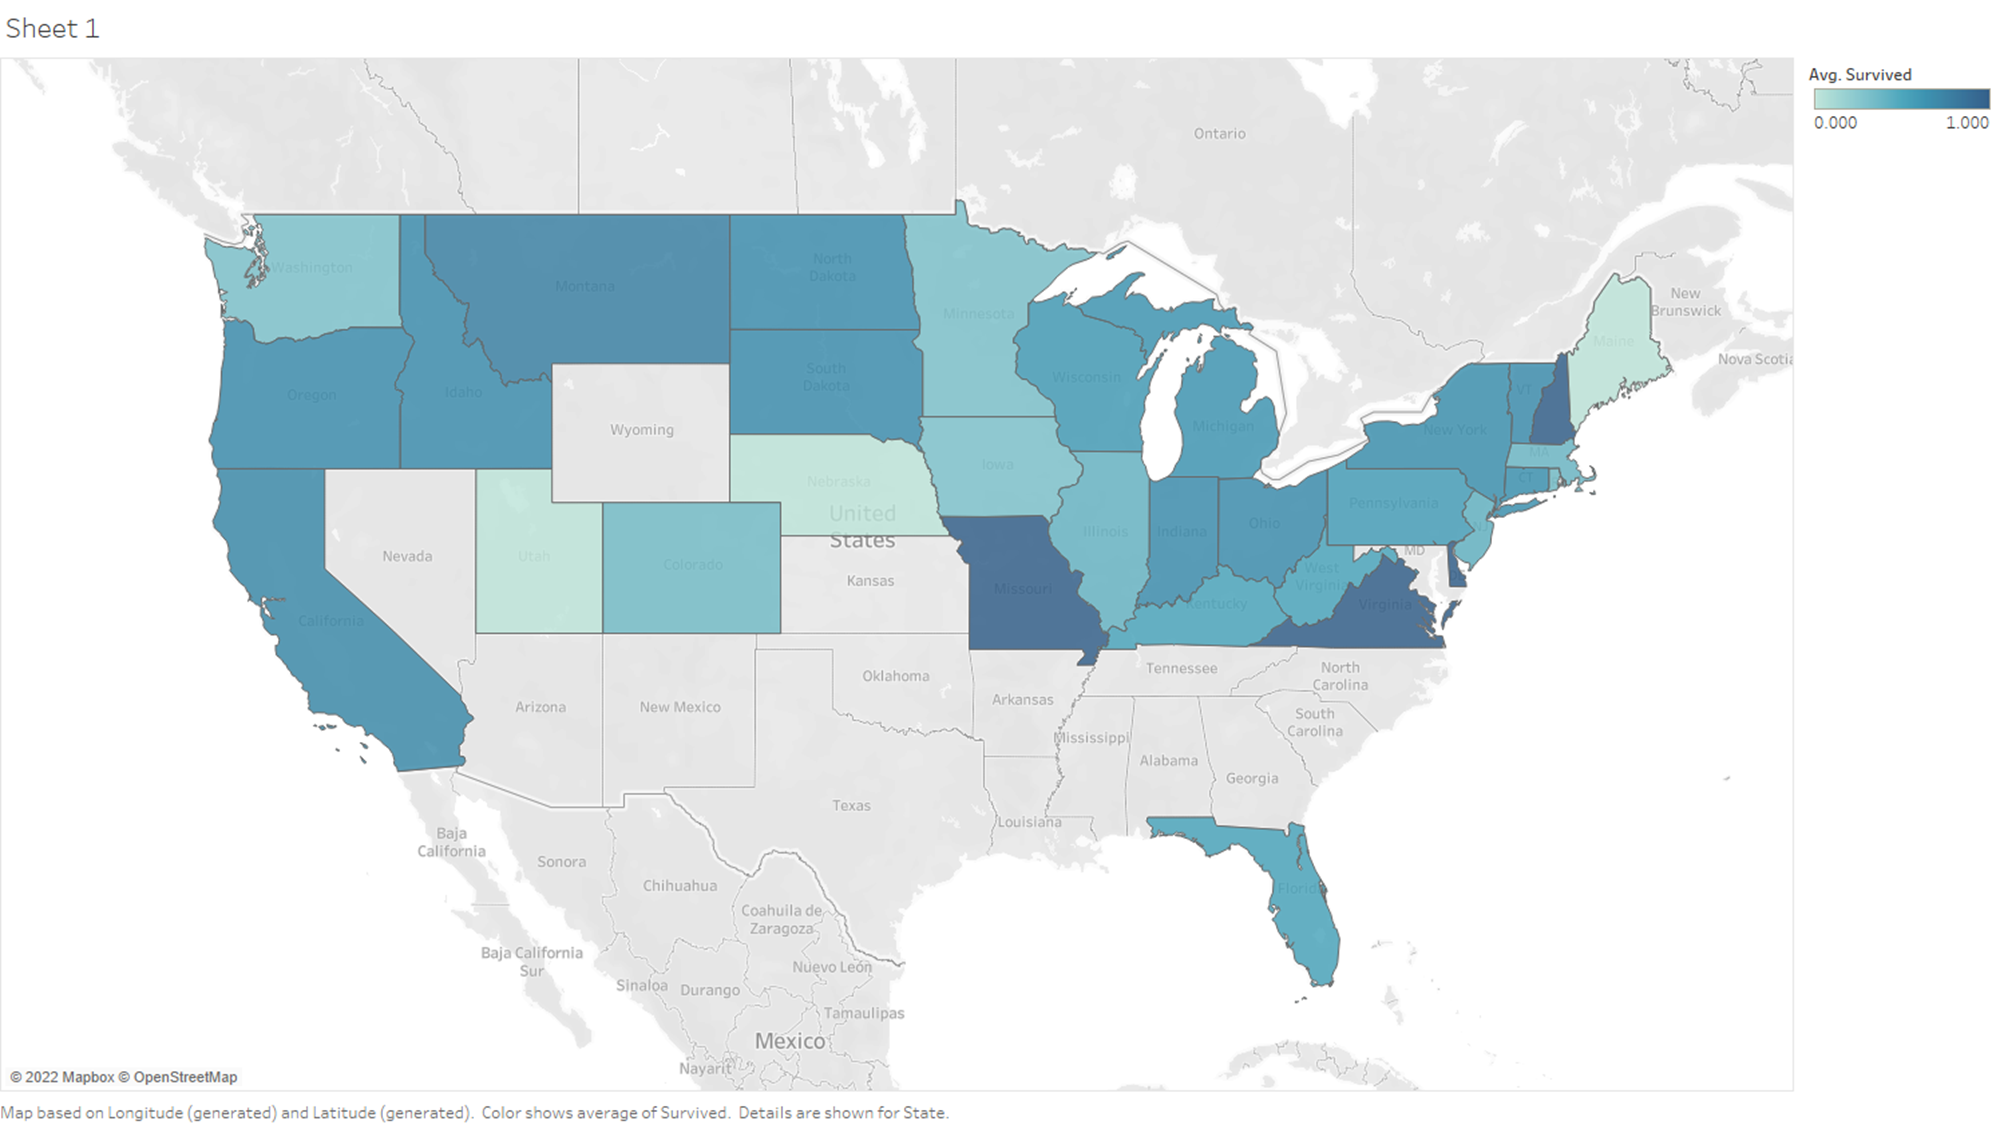